In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LinearRegression, SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

Загрузим данные.

In [ ]:
filename = 'data_prepared.csv'
df = pd.read_csv(filename, sep=',')

# Обучение моделей

## Общие методы

Метод draw_bar рисует распределение в зависимости от колонок. (Взято из 2 модуля)

In [ ]:
def draw_bar(data, axes=None, **kwargs):
    sns.barplot(x=data[0], y=data[1], ax=axes, **kwargs)

Метод `print_metrics` выводит метрики для предсказанных значений

- `classification_report` печатает отчет о метриках, в том числе ошибки 1 и 2 рода;
- `confusion_matrix` показывает, сколько из объектов были отнесены к правильному классу, а сколько - нет.

In [ ]:
def print_metrics(y_true=None, y_pred=None):
    if y_true is None or y_pred is None:
        print('No data to print metrix')
        return None, None
    print('Classification report.')
    cl_report = classification_report(y_true, y_pred, zero_division=0)
    print(cl_report)
    print('Confusion matrix.')
    conf_matrix = confusion_matrix(y_true, y_pred)
    print(conf_matrix)
    return cl_report, conf_matrix

Метод `fit_predict` обучает модель на размеченных данных и предсказывает метки для тестовой выборки. Особенности:
1. Создает базовую модель `model` с параметрами `model_params`.
1. Выполняет подбор гиперпараметров из дополнительных аргументов, переданных в функцию.
1. Если не передан `X_test`, на выход вместо предсказанных значений подается `None`.

In [ ]:
def fit_predict(X_train=[], y_train=[], X_test=None, model=DecisionTreeClassifier, model_params={},
                verbose=False, **params):
    if verbose:
        print('Обучаем {} модель.'.format(model))
    base_est = model(**model_params)
    est = GridSearchCV(base_est, params)
    est.fit(X_train, y_train)
    if verbose:
        print('Получили лучшие параметры модели: {}.'.format(est.best_params_))
    if X_test is None:
        return est.best_model_, est.best_params_, None
    y_pred = est.predict(X_test)
    return est.best_estimator_, est.best_params_, y_pred

Метод `fit_print` обучает модель на размеченных данных, предсказывает метки для тестовой выборки и печатает отчет. На выход - модель и параметры.

Для задачи классификации умеет преобразовывать данные в бинарный вид $(- \infty; + \infty) \rightarrow \{0, 1\}$. Разделителем является значение 0.5

In [ ]:
def fit_train(X_train=[], y_train=[], X_test=None, y_test=None, model=DecisionTreeClassifier, model_params={},
                verbose=False, is_classification=True, sep=0.5, **params):
    estimator, params, y_pred = fit_predict(X_train=X_train, y_train=y_train, X_test=X_test,
                                                            model=model, model_params=model_params,
                                                            verbose=verbose, **params)
    if is_classification:
        y_pred = np.where(y_pred > sep, 1, 0)
    print_metrics(y_true=y_test, y_pred=y_pred)
    return estimator, params

## Формироване признакового пространства

Как уже было показано, некоторые признаки сильно влияют на целевую переменную `risk_flag`, а некоторые слабее. Выделим колонки, которые влияют сильнее всего. Их и оставим в качестве признаков. Весь код возьмем из модуля 2.

In [ ]:
target = 'risk_flag'
X = df.drop(target, axis=1)
y = df[target]
# 0.001 - лучшее значение alpha по предыдущему модулю
model = Lasso(alpha=0.001)
model.fit(X, y)

Lasso(alpha=0.001)

In [ ]:
eps = 1e-6
num_meaningful_params = np.sum(np.where(np.abs(model.coef_) - eps > 0, 1, 0))
num_meaningful_params

10

In [ ]:
best_columns=df.columns[np.where(np.abs(model.coef_) - eps > 0)]
best_columns

Index(['age', 'experience', 'married', 'car_ownership', 'current_job_years',
       'current_house_years', 'state_Kerala', 'state_Sikkim',
       'house_ownership_norent_noown', 'house_ownership_owned'],
      dtype='object')

Вспомним зависимость признаков от целевой переменной.

По величине:

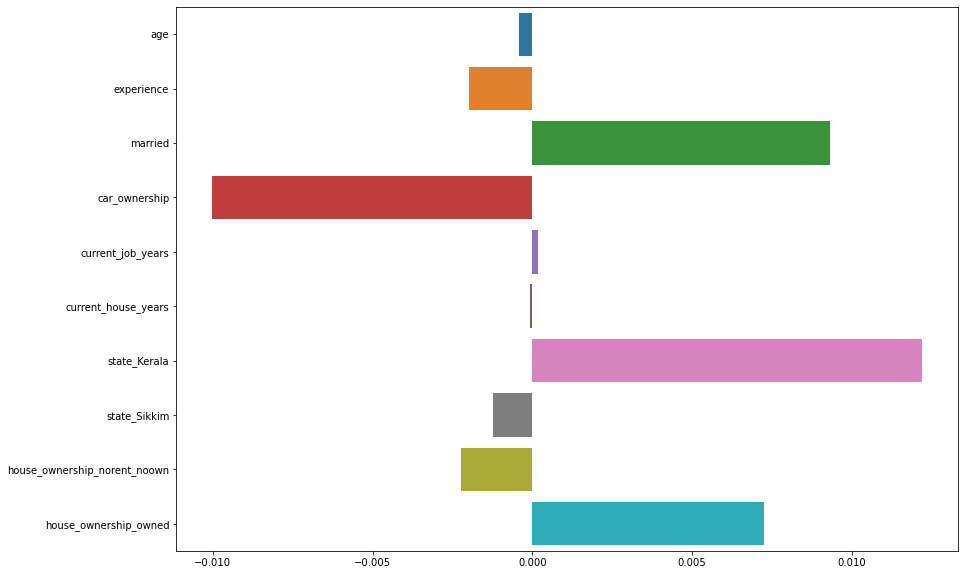

In [ ]:
fig, axes = plt.subplots(figsize=(14, 1*num_meaningful_params))
draw_bar([
    model.coef_[np.where(np.abs(model.coef_) - eps > 0)],
    best_columns], orient='h')

По абсолютному значению:

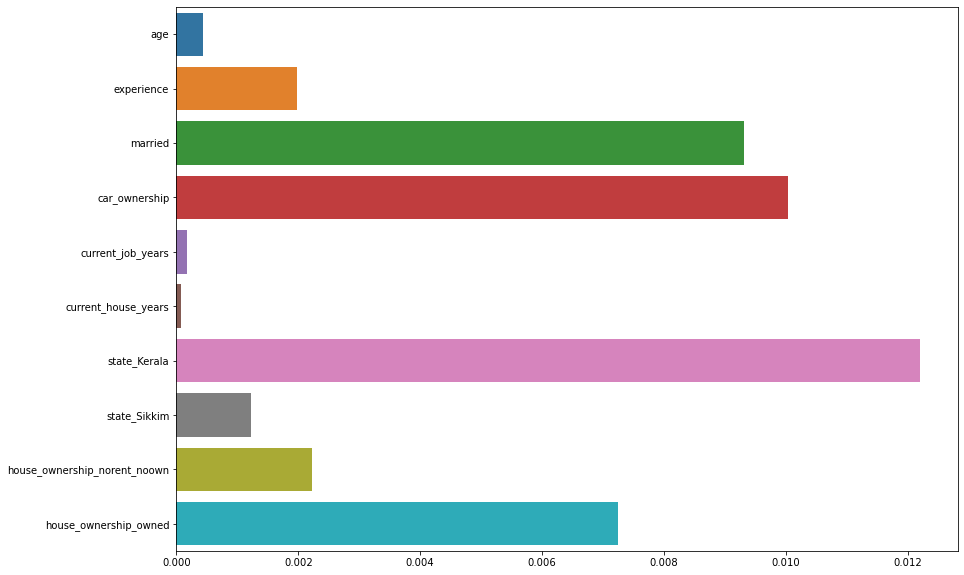

In [ ]:
fig, axes = plt.subplots(figsize=(14, 1*num_meaningful_params))
draw_bar([
    np.abs(model.coef_)[np.where(np.abs(model.coef_) - eps > 0)],
    best_columns], orient='h')

Наличие машины может негативно повлиять на риск выдачи, ибо у человека, владеющего машиной, в случае неуплаты можно ее конфисковать.

Видим, что штат Kerala имеет очень большой риск выдачи, возможно, потому что этот штат неблагополучный. В противоположность ему штат Sikkim, по-видимому, является благополучным и риски уменьшаются.

Чем больше у человека возраст, опыт, тем меньше риски - логично, что не отдавать кредит свойственно более молодому поколению.

Однако, доход также должен влиять на риски, хотя и, может быть, в меньшей степени и/или нелинейно. Поэтому к данным полям добавим колонку `income`

In [ ]:
best_columns = np.append(best_columns, 'income')
best_columns

array(['age', 'experience', 'married', 'car_ownership',
       'current_job_years', 'current_house_years', 'state_Kerala',
       'state_Sikkim', 'house_ownership_norent_noown',
       'house_ownership_owned', 'income'], dtype=object)

В связи с этим оставляем только эти признаки и целевую переменную.

## Разбиение данных на обучающую и тестовую выборку

Будем дополнительно центрировать не бинарные значения.

In [ ]:
X = df[best_columns]
y = df[target]

Будем стандартизировать не-булевые значения

In [ ]:
numeric_cols = ['age', 'experience', 'current_job_years', 'current_house_years', 'income']
non_numeric = list(set(best_columns) - set(numeric_cols))
non_numeric

['house_ownership_owned',
 'state_Kerala',
 'house_ownership_norent_noown',
 'car_ownership',
 'state_Sikkim',
 'married']

In [ ]:
scaler = StandardScaler()
X_num = scaler.fit_transform(X[numeric_cols])
X_prep = np.hstack((X_num, X[non_numeric].values))
X_prep.shape

(252000, 11)

Разбиение на обучение и тест выполняем случайным образом. Мы не имеем каких-либо данных по дате обращения в компанию, поэтому имеет смысл подготовиться ко всем случаям и сделать разбиение случайно.

В этом есть еще одно преимущество: во 2 модуле мы заметили дисбаланс классов, от которого мы можем избавиться, поставив `stratify=y` в разбиении на обучение и тест.

Подумаем, сколько значений оставить на тест. Так как датасет достаточно большой (`252000` значений), имеет смысл сделать достаточно большую тестовую выборку, скажем, `25%`.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_prep, y, stratify=y, test_size=0.25)

Объединим все это в одну функцию

In [ ]:
def prepare_train_test(df, colums=['age', 'experience', 'married', 'car_ownership',
       'current_job_years', 'current_house_years', 'state_Kerala',
       'state_Sikkim', 'house_ownership_norent_noown',
       'house_ownership_owned', 'income'],
                       num_cols=['age', 'experience', 'current_job_years', 'current_house_years', 'income'], target='risk_flag'):
    # get columns
    X = df[best_columns]
    y = df[target]
    # Standartize features
    scaler = StandardScaler()
    X_num = scaler.fit_transform(X[numeric_cols])
    X_prep = np.hstack((X_num, X[non_numeric].values))
    # Split into train, test
    X_train, X_test, y_train, y_test = train_test_split(X_prep, y, stratify=y, test_size=0.25)
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = prepare_train_test(df)
print(np.sum(y_train == 1), np.sum(y_train == 0), y_train.shape)
print(np.sum(y_test == 1), np.sum(y_test == 0), y_test.shape)

23247 165753 (189000,)
7749 55251 (63000,)


## Классификация

Будем обучать следующие модели:
- [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)
- [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
- [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)
- [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
- [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- [GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
- [BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)
- [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Задача классификации - не просто обучить модели и вывести точность, но еще и сравнить их между собой и выбрать лучшую (или несколько лучших), сохранить их. Также необходимо провести подбор гиперпараметров с целью улучшения качества предсказания модели.

Пройдемся по каждой из вышеперечисленных моделей, будем аргументировать выбор гиперпараметров для модели.

### [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

- `max_depth`: Не строим сильно глубокое дерево - на 12 признаках возможно переобучение.
- `min_samples_leaf`: При малом числе признаков, в которых всего-то 5 числовых нет смысла делать в листе мало значений. Существует риск переобучения, если будем доходить до листа с 1 элементом.

In [ ]:
DTC, params_DTC = fit_train(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
                            model=DecisionTreeClassifier, verbose=True, max_depth=range(12, 37, 4),
                           min_samples_leaf=range(1, 20, 3))

Обучаем <class 'sklearn.tree._classes.DecisionTreeClassifier'> модель.
Получили лучшие параметры модели: {'max_depth': 32, 'min_samples_leaf': 13}.
Classification report.
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     55251
           1       0.55      0.29      0.38      7749

    accuracy                           0.88     63000
   macro avg       0.73      0.63      0.66     63000
weighted avg       0.86      0.88      0.87     63000

Confusion matrix.
[[53370  1881]
 [ 5483  2266]]


Дерево решений отработало достаточно хорошо с точки зрения предсказания классов. Точность модели - `88%`. Однако всего `38%` объектов модель отнесла к классу 1.

### [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
Несмотря на то, что данная модель была создана для регрессии, она может достаточно хорошо предсказывать в задаче классификации.
- Выполним нормализацию данных - модель хорошо работает с нормализованными данными

In [ ]:
model_params = {
    'normalize': True
}
LM, params_LM = fit_train(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
                            model=LinearRegression, verbose=True, model_params=model_params,
                         positive=['False', 'True'])

Обучаем <class 'sklearn.linear_model._base.LinearRegression'> модель.
Получили лучшие параметры модели: {'positive': 'False'}.
Classification report.
              precision    recall  f1-score   support

           0       0.88      1.00      0.93     55251
           1       0.00      0.00      0.00      7749

    accuracy                           0.88     63000
   macro avg       0.44      0.50      0.47     63000
weighted avg       0.77      0.88      0.82     63000

Confusion matrix.
[[55251     0]
 [ 7749     0]]


Данные распределены нелинейно - модель переобучилась (предсказывает один из классов - 1). Точность аналогичная дереву решений `88%`.

### [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)
- `alpha` Для отбора параметров был выставлен 0.001, поэтому сейчас не имеет смысла делать такой же или ниже.

In [ ]:
model_params = {
    'normalize': True
}
Lasso, params_Lasso = fit_train(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
                            model=Lasso, verbose=True, model_params=model_params,
                         alpha=[0.01, 0.1, 0.5, 1.0], positive=[False, True])

Обучаем <class 'sklearn.linear_model._coordinate_descent.Lasso'> модель.
Получили лучшие параметры модели: {'alpha': 0.01, 'positive': False}.
Classification report.
              precision    recall  f1-score   support

           0       0.88      1.00      0.93     55251
           1       0.00      0.00      0.00      7749

    accuracy                           0.88     63000
   macro avg       0.44      0.50      0.47     63000
weighted avg       0.77      0.88      0.82     63000

Confusion matrix.
[[55251     0]
 [ 7749     0]]


Данные распределены нелинейно - модель переобучилась (предсказывает один из классов - 1). Точность аналогичная дереву решений 88%.

### [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
 Мы уже пробовали регуляризацию L2, попробуем теперь регуляризацию L1.

In [ ]:
model_params = {
    'penalty': 'l1',
    'max_iter': 2000
}
SGD, params_SGD = fit_train(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
                            model=SGDClassifier, verbose=True, model_params=model_params,
                         alpha=[0.0001, 0.001, 0.01])

Обучаем <class 'sklearn.linear_model._stochastic_gradient.SGDClassifier'> модель.
Получили лучшие параметры модели: {'alpha': 0.0001}.
Classification report.
              precision    recall  f1-score   support

           0       0.88      1.00      0.93     55251
           1       0.00      0.00      0.00      7749

    accuracy                           0.88     63000
   macro avg       0.44      0.50      0.47     63000
weighted avg       0.77      0.88      0.82     63000

Confusion matrix.
[[55251     0]
 [ 7749     0]]


Модель переобучилась. Видимо, не следует использовать линейные модели для данной задачи.

### [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

Скорее всего данная модель не будет быстро обучаться. Причина в том, что модель высчиляет попарные расстояния между объектами.
- `n_neighbors` данный параметр показывает количество соседей, по которым будет производиться вычисления. В нашем случае можно взять побольше соседей. (3, 5)

In [ ]:
KNN, params_KNN = fit_train(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
                            model=KNeighborsClassifier, verbose=True, n_neighbors=[3, 5])

Обучаем <class 'sklearn.neighbors._classification.KNeighborsClassifier'> модель.
Получили лучшие параметры модели: {'n_neighbors': 5}.
Classification report.
              precision    recall  f1-score   support

           0       0.91      0.96      0.93     55251
           1       0.49      0.31      0.38      7749

    accuracy                           0.88     63000
   macro avg       0.70      0.63      0.66     63000
weighted avg       0.86      0.88      0.86     63000

Confusion matrix.
[[52787  2464]
 [ 5361  2388]]


Качество данной модели радует глаз. По сравнению с деревом решений, данная модель лучше предсказывает целевой признак. Однако, и ошибок данная модель совершает больше. Поэтому, если Вам важнее предсказать класс 0, берите `DecisionTreeClassifier`, а если класс 1 - тогда `KNeighborsClassifier`.

Для данной задачи важнее предсказать класс 1 (есть риск), поэтому данная модель лучше дерева решений.

### [GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)

Данный классификатор основан на наивном распределении Гаусса, поэтому не требует никаких параметров.

In [ ]:
Gauss, params_Gauss = fit_train(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
                            model=GaussianNB, verbose=True)

Обучаем <class 'sklearn.naive_bayes.GaussianNB'> модель.
Получили лучшие параметры модели: {}.
Classification report.
              precision    recall  f1-score   support

           0       0.88      0.98      0.93     55251
           1       0.16      0.03      0.05      7749

    accuracy                           0.86     63000
   macro avg       0.52      0.50      0.49     63000
weighted avg       0.79      0.86      0.82     63000

Confusion matrix.
[[54213  1038]
 [ 7544   205]]


Как мы видим, полнота класса 0 `98%`, однако общая точность всего `86%`.

Считаем, ч/то данная модель лучше линейных, но хуже дерева решений.

### [BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)

Принцип - обучение на поднаборах данных, затем классификаторы голосуют за лучший класс.

- `n_estimators` - число голосующих моделей. Так как базовая модель - дерево решений, не имеет смысла ставить много моделей.

In [ ]:
model_params = {
    'n_estimators': 15
}
BC, params_BC = fit_train(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
                            model=BaggingClassifier, model_params=model_params, verbose=True)

Обучаем <class 'sklearn.ensemble._bagging.BaggingClassifier'> модель.
Получили лучшие параметры модели: {}.
Classification report.
              precision    recall  f1-score   support

           0       0.92      0.95      0.94     55251
           1       0.55      0.43      0.48      7749

    accuracy                           0.89     63000
   macro avg       0.73      0.69      0.71     63000
weighted avg       0.88      0.89      0.88     63000

Confusion matrix.
[[52529  2722]
 [ 4452  3297]]


Как мы видим, по всем параметрам, кроме полноты и ошибок класса 0, данная модель лучше, чем `KNN` и `DecisionTreeClassifier`. Однако, мы договорились, что будем улучшать предсказания класса 1, поэтому эта модель - лучшая из вышерассмотренных

Предсказывает класс 1 лучше, ошибается меньше.

### [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

- `n_estimators` - не нужно много деревьев ставить в этой задаче, модели достаточно некоторого количества, чтобы выбрать класс.

In [ ]:
model_params = {
    'n_estimators': 30
}
RFC, params_RFC = fit_train(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test,
                            model=RandomForestClassifier, model_params=model_params, verbose=True)

Обучаем <class 'sklearn.ensemble._forest.RandomForestClassifier'> модель.
Получили лучшие параметры модели: {}.
Classification report.
              precision    recall  f1-score   support

           0       0.92      0.95      0.94     55251
           1       0.55      0.41      0.47      7749

    accuracy                           0.89     63000
   macro avg       0.74      0.68      0.70     63000
weighted avg       0.87      0.89      0.88     63000

Confusion matrix.
[[52702  2549]
 [ 4593  3156]]


Как мы видим, по всем параметрам, кроме полноты и ошибок класса 0, данная модель лучше, чем `KNN` и `DecisionTreeClassifier`. Однако, мы договорились, что будем улучшать предсказания класса 1, поэтому эта модель - одна из лучших из вышерассмотренных. Помимо этого, она немного хуже предсказывает по сравнению с `BaggingClassifier`.

Предсказывает класс 1 лучше, ошибается меньше, чем `KNN`.

# Вывод

На текущих данных можно сделать вывод, что некоторые модели (`BaggingClassifier`) обучаются хорошо, а некоторые (`LinearRegression`) - плохо.

Составим список моделей в порядке убывания качества (сверху - лучшие):
1. [BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) - лучшая модель по многим параметрам
1. [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) - немного уступает предыдущей модели, однако все еще лучшая
1. [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) - неплохая точность
1. [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) - неплохая точность
1. [GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html) - модель предсказывает слабо
1. [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) - модель переобучилась и предсказывает доминирующий класс
1. [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) - модель переобучилась и предсказывает доминирующий класс
1. [SGDClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)- модель переобучилась и предсказывает доминирующий класс

Видим, что лучше всего отработали ансамбли, а хуже всего - линейные модели.

## Сериализация лучших моделей

Проведем сериализацию четырех лучших моделей c помощью модуля `pickle`.

Напишем метод, сериализующий модель в файл.

In [ ]:
def serialize_to_file(model, filename='0.dat'):
    with open(filename, 'wb') as fin:
        pickle.dump(model, fin)
    return filename

Напишем метод, десериализующий модель из файла.

In [ ]:
def deserialize_from_file(filename='0.dat'):
    with open(filename, 'rb') as fout:
        return pickle.load(fout)

Проверим работу сериализации и десериализации на дереве решений.

In [ ]:
filename = serialize_to_file(DTC, filename='DTC.dat')

In [ ]:
DTC_des = deserialize_from_file(filename=filename)

Проверим идентичность предсказаний исходной и десериализованой модели.

In [ ]:
_, conf_matrix_DTC = print_metrics(y_true=y_test, y_pred=DTC.predict(X_test))
_, conf_matrix_DTC_des = print_metrics(y_true=y_test, y_pred=DTC.predict(X_test))

conf_matrix_DTC == conf_matrix_DTC_des

Classification report.
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     55251
           1       0.55      0.29      0.38      7749

    accuracy                           0.88     63000
   macro avg       0.73      0.63      0.66     63000
weighted avg       0.86      0.88      0.87     63000

Confusion matrix.
[[53370  1881]
 [ 5483  2266]]
Classification report.
              precision    recall  f1-score   support

           0       0.91      0.97      0.94     55251
           1       0.55      0.29      0.38      7749

    accuracy                           0.88     63000
   macro avg       0.73      0.63      0.66     63000
weighted avg       0.86      0.88      0.87     63000

Confusion matrix.
[[53370  1881]
 [ 5483  2266]]


array([[ True,  True],
       [ True,  True]])

Действительно, оригинальный объект и сериализованный идентичны - они одинаково предсказывают. Сериализуем модели:

- [BaggingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) - файл `BC.dat`
- [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) - файл `RFC.dat`
- [KNeighborsClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) - файл `KNN.dat`
- [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) - файл `DTC.dat`

In [ ]:
filenames = ['BC.dat', 'RFC.dat', 'KNN.dat', 'DTC.dat']
models = [BC, RFC, KNN, DTC]

for filename, model in zip(filenames, models):
    serialize_to_file(model, filename=filename)

Сериализация прошла успешно, модели сохранены в файлах.